In [2]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from numpy import median

# Sensors

In [2]:
!pwd

/Users/Joanna/Documents/PhD/Research/Polaris/NLE/Git/new/3d-tracking-at-gt-main/Demo1_Walking


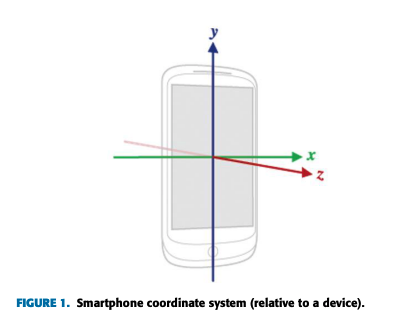

In [4]:
from IPython.display import Image
Image(filename='axes.png')

## Sensor Calibration and Mapping Function

In [4]:
# a: accleration measurement
# x: 1 - x axis; 2 - y axis; 3 - z axis

def accOff(a, x):
    if x == 1:
        a -= acc_offset1 # derived from static measurement beforehand
    elif x == 2:
        a -= acc_offset2 # derived from static measurement beforehand
    else:
        a -= acc_offset3 # derived from static measurement beforhand
    return a

In [5]:
# a: geomagnetic field strength
# b: iron bias compensation

def mapMag(a, b):
    res = (a - b)/120 * 2*math.pi
    return res

In [6]:
def mapGyro(a):
    return a*0.06

## Time Processing

In [7]:
def timeStamp(a):
    return 1.0*(a- min(a))/1000000000 

## 1st and 2nd Integration 

In [8]:
def inTegrate(a, time):
    pp = np.zeros(len(a))
    
    for i in range(1, len(a)):
        pp[i] = pp[i-1] + a[i]*time[i]
    
    return pp

In [9]:
def doubleTegrate(accx, time):
    T = np.zeros(len(accx))
    for i in range(len(time)-1):
        T[i+1] =  1.0*(time[i+1] - time[i])
    
    xx = np.zeros(len(accx))
    vx = np.zeros(len(accx))
    vx[0] = 0
    vx[1] = accx[1]*T[1]
    xx[1] = 0.5*accx[1]*T[1]**2

    for i in range(2,len(accx)):
        vx[i] = accx[i-1]*T[i] + vx[i-1]
        xx[i] = vx[i]*T[i] + 0.5*accx[i]*T[i]**2 + xx[i-1]
    
    return xx

# Kalman Filter

In [11]:
def defKF(z, R, Q, x):

    n = len(z)
    sz = (n,) 

    x_hat=np.zeros(sz)      # posteri estimate of x
    P=np.zeros(sz)          # posteri error estimate
    xhat_=np.zeros(sz)      # priori  estimate of x
    P_=np.zeros(sz)         # priori  error estimate
    K=np.zeros(sz)          # gain 

    # intial guesses
    x_hat[0] = z[0]
    P[0] = 1.0

    for k in range(0,n):
        
        # time update
        xhat_[k] = x_hat[k-1]
        P_[k] = P[k-1]+Q

        # measurement update
        K[k] = P_[k]/(P_[k]+R)
        x_hat[k] = xhat_[k]+K[k]*(z[k]-xhat_[k])
        P[k] = (1-K[k])*P_[k]
        
    return x_hat 

In [12]:
Q = 1e-5   # process variance
R = 0.1**2 # estimate of measurement variance
x = -.25

In [22]:
yhat = defKF(gyro1_total, R, Q, x)

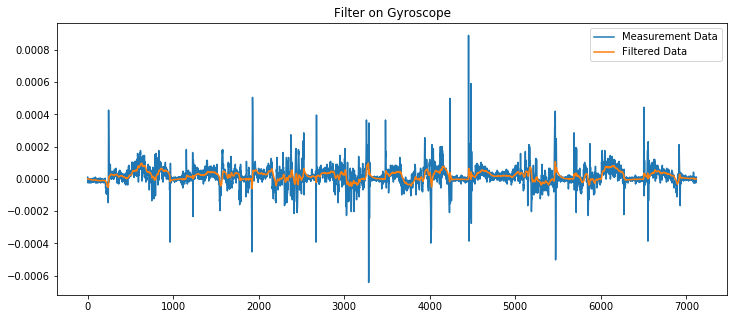

In [536]:
plt.plot(gyro1_total)
plt.plot(yhat)
plt.title("Filter on Gyroscope")
plt.legend(["Measurement Data", "Filtered Data"])

# 1. Accelerometer Calibration: Bias Compensation + Kalman Filter

## *Noise Distribution of Accelerations can be fitted with Gaussian Distribution

## Static Calibration

In [14]:
std = pd.read_csv('sensors/acc1.csv', index_col = None, header = None)
std = std[std[1]==' ACC_UN']

In [15]:
time = std[0].values
time = timeStamp(time)

In [16]:
acc1 = std[2].values
acc2 = std[3].values
acc3 = std[4].values

In [17]:
xhat1 = defKF(acc1, R, Q, x)
xhat2 = defKF(acc2, R, Q, x)
xhat3 = defKF(acc3, R, Q, x)

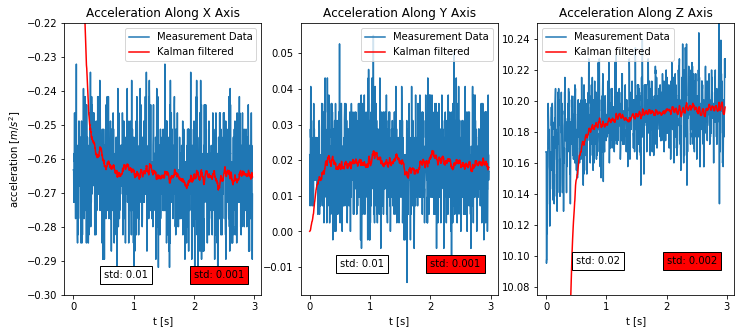

In [18]:
plt.rcParams['figure.figsize'] = (12, 5)
plt.subplot(131)
plt.plot(time, acc1)
plt.plot(time, xhat1,'r-')
plt.text(2,-0.295,'std: 0.001', bbox=dict(facecolor='red', alpha=1))
plt.text(0.5,-0.295,'std: 0.01', bbox=dict(facecolor='white', alpha=1))
plt.ylim([-0.3,-0.22])
plt.xlabel('t [s]')
plt.ylabel('acceleration [$m/s^2$]')
plt.title('Acceleration Along X Axis')
plt.legend(['Measurement Data','Kalman filtered'],loc='upper right')

plt.subplot(132)
plt.plot(time, acc2)
plt.plot(time, xhat2,'r-')
plt.text(2,-0.01,'std: 0.001', bbox=dict(facecolor='red', alpha=1))
plt.text(0.5,-0.01,'std: 0.01', bbox=dict(facecolor='white', alpha=1))
plt.xlabel('t [s]')
plt.title('Acceleration Along Y Axis')
plt.legend(['Measurement Data','Kalman filtered'],loc='upper right')

plt.subplot(133)
plt.plot(time, acc3)
plt.plot(time, xhat3,'r-')
plt.text(2,10.095,'std: 0.002', bbox=dict(facecolor='red', alpha=1))
plt.text(0.5,10.095,'std: 0.02', bbox=dict(facecolor='white', alpha=1))
plt.xlabel('t [s]')
plt.ylim([10.075,10.25])
plt.title('Acceleration Along Z Axis')
plt.legend(['Measurement Data','Kalman filtered'],loc='upper left')

In [1169]:
acc_offset1 = median(xhat1)
acc_offset2 = median(xhat2)
acc_offset3 = median(xhat3)
print('acc offset x:', acc_offset1,'offset y axis:', acc_offset2,'offset z axis:', acc_offset3)

('acc offset x:', -0.26429820495860523, 'offset y axis:', 0.01904151454042118, 'offset z axis:', 10.190481252274513)


In [1026]:
print('--------------------------')
print('Meas std x axis', round(np.std(acc1[800:-1]),3))
print('KF   std x axis', round(np.std(xhat1[800:-1]),3))
print('--------------------------')
print('Meas std y axis', round(np.std(acc2[800:-1]),3))
print('KF   std y axis', round(np.std(xhat2[800:-1]),3))
print('--------------------------')
print('Meas std z axis', round(np.std(acc3[800:-1]),3))
print('KF   std z axis', round(np.std(xhat3[800:-1]),3))
print('--------------------------')

--------------------------
('Meas std x axis', 0.011)
('KF   std x axis', 0.001)
--------------------------
('Meas std y axis', 0.01)
('KF   std y axis', 0.001)
--------------------------
('Meas std z axis', 0.018)
('KF   std z axis', 0.002)
--------------------------


In [945]:
acc_noise1 = acc1 - acc_offset1
acc_noise2 = acc2 - acc_offset2
acc_noise3 = acc3 - acc_offset3

Text(0.5,1,u'Acceleration Noise Along Z axis')

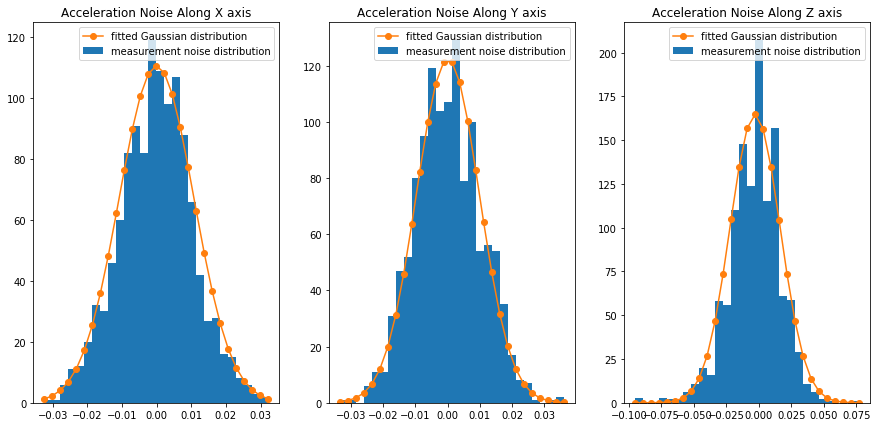

In [953]:
import scipy.stats as stats
plt.rcParams['figure.figsize'] = (15, 7)

plt.subplot(131)
n, bins, patches = plt.hist(acc_noise1, 28)
fit = 3*stats.norm.pdf(bins, np.mean(acc_noise1), np.std(acc_noise1))
plt.plot(bins,fit,'-o')
plt.legend(['fitted Gaussian distribution','measurement noise distribution'])
plt.title('Acceleration Noise Along X axis')

plt.subplot(132)
n, bins, patches = plt.hist(acc_noise2, 28)
fit = 3*stats.norm.pdf(bins, np.mean(acc_noise2), np.std(acc_noise2))
plt.plot(bins,fit,'-o')
plt.legend(['fitted Gaussian distribution','measurement noise distribution'])
plt.title('Acceleration Noise Along Y axis')

plt.subplot(133)
n, bins, patches = plt.hist(acc_noise3, 28)
fit = 8*stats.norm.pdf(bins, np.mean(acc_noise3), np.std(acc_noise3))
plt.plot(bins,fit,'-o')
plt.legend(['fitted Gaussian distribution','measurement noise distribution'])
plt.title('Acceleration Noise Along Z axis')

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# 2. Magtometer Calibration: Offset Compensation + Scalar Factor

## * May Need to Rotate to Calibrate before Using 

## 2.1 Static Calibration

### Noise Distribution of Magnitude is not close to Gaussian Distribution

In [1039]:
std = pd.read_csv('sensors/acc1.csv', index_col = None, header = None)
std = std[std[1]==' MAG_UN']

time = std[0].values
time = timeStamp(time)

In [1040]:
mag1 = mapMag(std[2].values, std[5].values)
mag2 = mapMag(std[3].values, std[6].values)
mag3 = mapMag(std[4].values, std[7].values)

In [1041]:
mag1F = defKF(mag1, R, Q, x)
mag2F = defKF(mag2, R, Q, x)
mag3F = defKF(mag3, R, Q, x)

Text(0.5,1,u'Magnitude Noise Along Z axis')

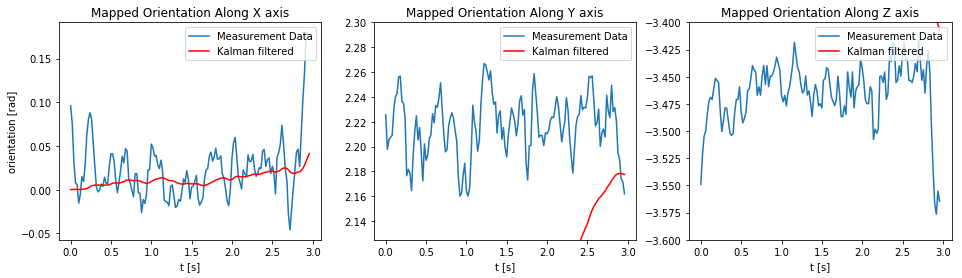

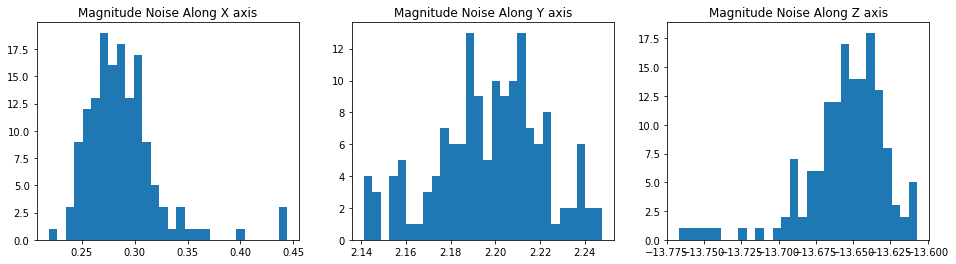

In [1052]:
plt.figure
plt.rcParams['figure.figsize'] = (16, 4)
plt.subplot(131)
plt.plot(time, mag1)
plt.plot(time, mag1F, 'r-')
plt.xlabel('t [s]')
plt.ylabel('orientation [rad]')
plt.legend(['Measurement Data','Kalman filtered'],loc='upper right')
plt.title('Mapped Orientation Along X axis')

plt.subplot(132)
plt.plot(time, mag2)
plt.plot(time, mag2F, 'r-')
plt.xlabel('t [s]')
plt.ylim([2.125, 2.3])
plt.legend(['Measurement Data','Kalman filtered'],loc='upper right')
plt.title('Mapped Orientation Along Y axis')

plt.subplot(133)
plt.plot(time, mag3)
plt.plot(time, mag3F, 'r-')
plt.xlabel('t [s]')
plt.ylim([-3.6, -3.4])
plt.legend(['Measurement Data','Kalman filtered'],loc='upper right')
plt.title('Mapped Orientation Along Z axis')

#
mag_offset1 = median(mag1)
mag_offset2 = median(mag2)
mag_offset3 = median(mag3)

mag_noise1 = mag1 - acc_offset1
mag_noise2 = mag2 - acc_offset2
mag_noise3 = mag3 - acc_offset3

plt.figure()
plt.rcParams['figure.figsize'] = (16, 4)

plt.subplot(131)
n, bins, patches = plt.hist(mag_noise1, 28)
plt.title('Magnitude Noise Along X axis')

plt.subplot(132)
n, bins, patches = plt.hist(mag_noise2, 28)
plt.title('Magnitude Noise Along Y axis')

plt.subplot(133)
n, bins, patches = plt.hist(mag_noise3, 28)
plt.title('Magnitude Noise Along Z axis')

# 2.2 Rotating Counter Clockwise for 3 Rounds

In [29]:
std = pd.read_csv('straightWalk/3round.csv', index_col = None, header = None)

### 2.2.1 Geomagnetic field strength (without hard iron calibration) along axes

In [30]:
time = std[std[1]==' MAG_UN'][0].values
time = timeStamp(time)

mag1 = std[std[1]==' MAG_UN'][2].values
mag2 = std[std[1]==' MAG_UN'][3].values
mag3 = std[std[1]==' MAG_UN'][4].values

Text(0.5,0,u'time (s)')

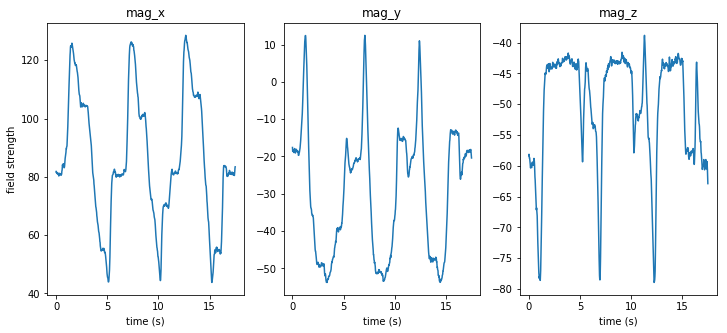

In [35]:
plt.subplot(131)
plt.plot(time, mag1)
plt.title('mag_x')
plt.xlabel('time (s)')
plt.ylabel('field strength')

plt.subplot(132)
plt.plot(time, mag2)
plt.title('mag_y')
plt.xlabel('time (s)')

plt.subplot(133)
plt.plot(time, mag3)
plt.title('mag_z')
plt.xlabel('time (s)')

## Iron Bias Compensation + Sclar Factor -> Mapping to [-pi, pi] 

### 2.2.2 Iron bias estimation along the axes 

(-3.141592653589793, 3.141592653589793)

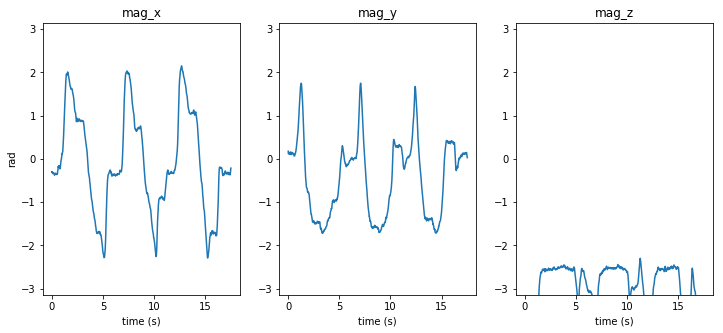

In [39]:
mag1_bias = std[std[1]==' MAG_UN'][5].values
mag2_bias = std[std[1]==' MAG_UN'][6].values
mag3_bias = std[std[1]==' MAG_UN'][7].values

mag1_total = mapMag(mag1, mag1_bias)
mag2_total = mapMag(mag2, mag2_bias)
mag3_total = mapMag(mag3, mag3_bias)

plt.subplot(131)
plt.plot(time, mag1_total)
plt.title('mag_x')
plt.xlabel('time (s)')
plt.ylabel('rad')
plt.ylim([-math.pi, math.pi])

plt.subplot(132)
plt.plot(time, mag2_total)
plt.title('mag_y')
plt.xlabel('time (s)')
plt.ylim([-math.pi, math.pi])

plt.subplot(133)
plt.plot(time, mag3_total)
plt.title('mag_z')
plt.xlabel('time (s)')
plt.ylim([-math.pi, math.pi])

# 2.3 CaliMapping Results: Rotation Along x Axis

(-3.141592653589793, 3.141592653589793)

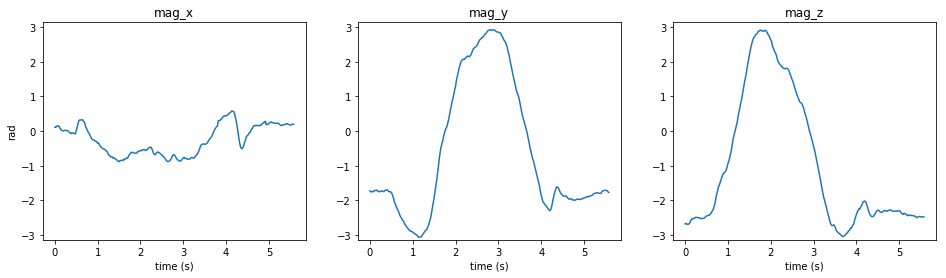

In [1074]:
std = pd.read_csv('sensors/x3.csv', index_col = None, header = None)

time = std[std[1]==' MAG_UN'][0].values
time = timeStamp(time)

mag1 = std[std[1]==' MAG_UN'][2].values
mag2 = std[std[1]==' MAG_UN'][3].values
mag3 = std[std[1]==' MAG_UN'][4].values

mag1_bias = std[std[1]==' MAG_UN'][5].values
mag2_bias = std[std[1]==' MAG_UN'][6].values
mag3_bias = std[std[1]==' MAG_UN'][7].values

mag1_total = mapMag(mag1, mag1_bias)
mag2_total = mapMag(mag2, mag2_bias)
mag3_total = mapMag(mag3, mag3_bias)

plt.subplot(131)
plt.plot(time, mag1_total)
plt.title('mag_x')
plt.ylabel('rad')
plt.xlabel('time (s)')
plt.ylim([-math.pi, math.pi])

plt.subplot(132)
plt.plot(time, mag2_total)
plt.title('mag_y')
plt.xlabel('time (s)')
plt.ylim([-math.pi, math.pi])

plt.subplot(133)
plt.plot(time, mag3_total)
plt.title('mag_z')
plt.xlabel('time (s)')
plt.ylim([-math.pi, math.pi])

# 2.3 CaliMapping Results: Rotation Along y Axis

(-3.141592653589793, 3.141592653589793)

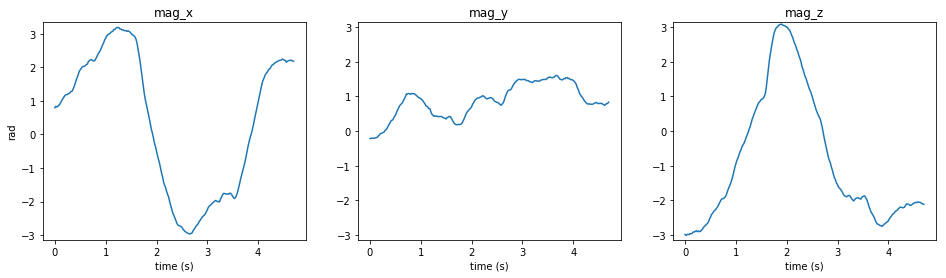

In [1078]:
std = pd.read_csv('sensors/y3.csv', index_col = None, header = None)

time = std[std[1]==' MAG_UN'][0].values
time = timeStamp(time)

mag1 = std[std[1]==' MAG_UN'][2].values
mag2 = std[std[1]==' MAG_UN'][3].values
mag3 = std[std[1]==' MAG_UN'][4].values

mag1_bias = std[std[1]==' MAG_UN'][5].values
mag2_bias = std[std[1]==' MAG_UN'][6].values
mag3_bias = std[std[1]==' MAG_UN'][7].values

mag1_total = mapMag(mag1, mag1_bias)
mag2_total = mapMag(mag2, mag2_bias)
mag3_total = mapMag(mag3, mag3_bias)

plt.subplot(131)
plt.plot(time, mag1_total)
plt.title('mag_x')
plt.ylabel('rad')
plt.xlabel('time (s)')
plt.ylim([-math.pi, math.pi+0.2])

plt.subplot(132)
plt.plot(time, mag2_total)
plt.title('mag_y')
plt.xlabel('time (s)')
plt.ylim([-math.pi, math.pi])

plt.subplot(133)
plt.plot(time, mag3_total)
plt.title('mag_z')
plt.xlabel('time (s)')
plt.ylim([-math.pi, math.pi])

# 2.4 CaliMapping Results: Rotation Along z Axis

(-3.141592653589793, 3.141592653589793)

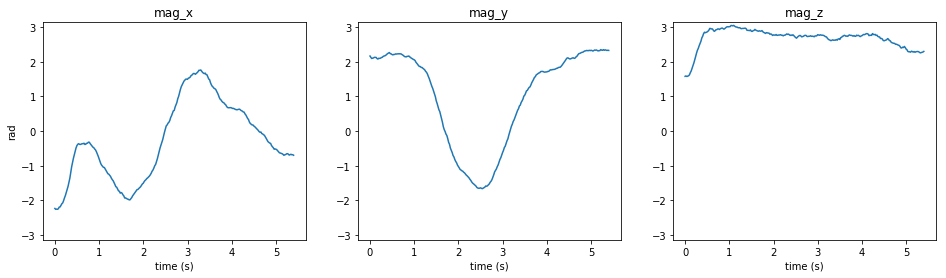

In [1077]:
std = pd.read_csv('sensors/z.csv', index_col = None, header = None)

time = std[std[1]==' MAG_UN'][0].values
time = timeStamp(time)

mag1 = std[std[1]==' MAG_UN'][2].values
mag2 = std[std[1]==' MAG_UN'][3].values
mag3 = std[std[1]==' MAG_UN'][4].values

mag1_bias = std[std[1]==' MAG_UN'][5].values
mag2_bias = std[std[1]==' MAG_UN'][6].values
mag3_bias = std[std[1]==' MAG_UN'][7].values

mag1_total = mapMag(mag1, mag1_bias)
mag2_total = mapMag(mag2, mag2_bias)
mag3_total = mapMag(mag3, mag3_bias)

plt.subplot(131)
plt.plot(time, mag1_total)
plt.title('mag_x')
plt.ylabel('rad')
plt.xlabel('time (s)')
plt.ylim([-math.pi, math.pi])

plt.subplot(132)
plt.plot(time, mag2_total)
plt.title('mag_y')
plt.xlabel('time (s)')
plt.ylim([-math.pi, math.pi])

plt.subplot(133)
plt.plot(time, mag3_total)
plt.title('mag_z')
plt.xlabel('time (s)')
plt.ylim([-math.pi, math.pi])

# 3. Gyroscope Calibration: Scalar Factor + Kalman Filter

## 3.1 Static Calibration

In [1125]:
std = pd.read_csv('sensors/acc1.csv', index_col = None, header = None)

In [1126]:
time = std[std[1]==' GYRO_UN'][0].values
time = timeStamp(time)

gyro1 = std[std[1]==' GYRO_UN'][2].values
gyro2 = std[std[1]==' GYRO_UN'][3].values
gyro3 = std[std[1]==' GYRO_UN'][4].values

In [1088]:
gyro1hat = defKF(gyro1, R, Q, x)
gyro2hat = defKF(gyro2, R, Q, x)
gyro3hat = defKF(gyro3, R, Q, x)

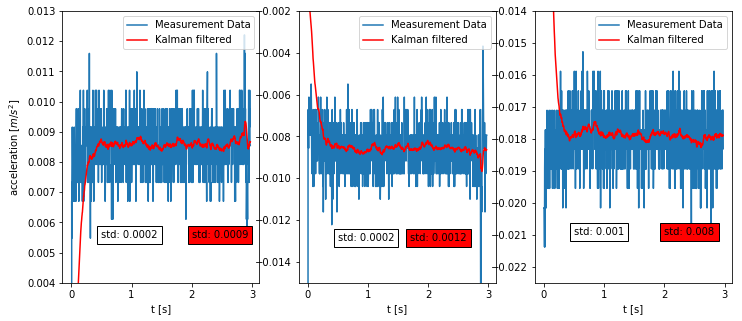

In [1109]:
plt.rcParams['figure.figsize'] = (12, 5)
plt.subplot(131)
plt.plot(time, gyro1)
plt.plot(time, gyro1hat,'r-')
plt.text(2,0.0055,'std: 0.0009', bbox=dict(facecolor='red', alpha=1))
plt.text(0.5,0.0055,'std: 0.0002', bbox=dict(facecolor='white', alpha=1))
plt.ylim([0.004,0.013])
plt.xlabel('t [s]')
plt.ylabel('acceleration [$m/s^2$]')
plt.legend(['Measurement Data','Kalman filtered'],loc='upper right')

plt.subplot(132)
plt.plot(time, gyro2)
plt.plot(time, gyro2hat,'r-')
plt.text(1.7,-0.013,'std: 0.0012', bbox=dict(facecolor='red', alpha=1))
plt.text(0.5,-0.013,'std: 0.0002', bbox=dict(facecolor='white', alpha=1))
plt.ylim([-0.015, -0.002])
plt.xlabel('t [s]')
plt.legend(['Measurement Data','Kalman filtered'],loc='upper right')

plt.subplot(133)
plt.plot(time, gyro3)
plt.plot(time, gyro3hat,'r-')
plt.text(2,-0.021,'std: 0.008', bbox=dict(facecolor='red', alpha=1))
plt.text(0.5,-0.021,'std: 0.001', bbox=dict(facecolor='white', alpha=1))
plt.xlabel('t [s]')
plt.ylim([-0.0225,-0.014])
plt.legend(['Measurement Data','Kalman filtered'],loc='upper right')

In [1106]:
print('--------------------------')
print('Meas std x axis', round(np.std(gyro1[800:-1]),4))
print('KF   std x axis', round(np.std(gyro1hat[800:-1]),4))
print('--------------------------')
print('Meas std y axis', round(np.std(gyro2[800:-1]),4))
print('KF   std y axis', round(np.std(gyro2hat[800:-1]),4))
print('--------------------------')
print('Meas std z axis', round(np.std(gyro3[800:-1]),4))
print('KF   std z axis', round(np.std(gyro3hat[800:-1]),4))
print('--------------------------')

--------------------------
('Meas std x axis', 0.0009)
('KF   std x axis', 0.0002)
--------------------------
('Meas std y axis', 0.0012)
('KF   std y axis', 0.0002)
--------------------------
('Meas std z axis', 0.0008)
('KF   std z axis', 0.0001)
--------------------------


In [1111]:
gyro_offset1 = median(gyro1hat)
gyro_offset2 = median(gyro2hat)
gyro_offset3 = median(gyro3hat)
print('acc offset x:', gyro_offset1,'offset y:', gyro_offset2,'offset z:', gyro_offset3)

('acc offset x:', 0.008558871261770273, 'offset y:', -0.008553759827055894, 'offset z:', -0.017868919408808664)


In [1112]:
gyro_noise1 = gyro1 - gyro_offset1
gyro_noise2 = gyro2 - gyro_offset2
gyro_noise3 = gyro3 - gyro_offset3

Text(0.5,1,u'Gyroscope Noise Along Z axis')

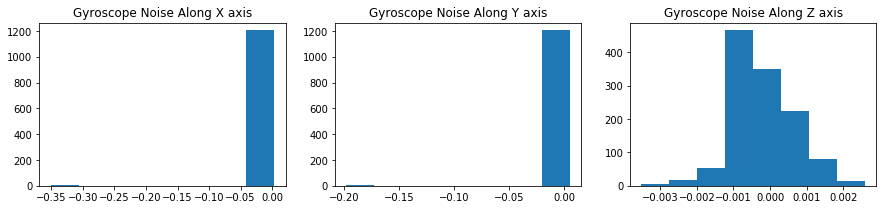

In [1120]:
import scipy.stats as stats
plt.rcParams['figure.figsize'] = (15, 3)

plt.subplot(131)
n, bins, patches = plt.hist(gyro_noise1, 8)
fit = 3*stats.norm.pdf(bins, np.mean(gyro_noise1), np.std(gyro_noise1))
#plt.plot(bins,fit,'-o')
plt.title('Gyroscope Noise Along X axis')

plt.subplot(132)
n, bins, patches = plt.hist(gyro_noise2, 8)
fit = 3*stats.norm.pdf(bins, np.mean(gyro_noise2), np.std(gyro_noise2))
#plt.plot(bins,fit,'-o')
plt.title('Gyroscope Noise Along Y axis')

plt.subplot(133)
n, bins, patches = plt.hist(gyro_noise3, 8)
fit = 8*stats.norm.pdf(bins, np.mean(gyro_noise3), np.std(gyro_noise3))
#plt.plot(bins,fit,'-o')
plt.title('Gyroscope Noise Along Z axis')

# 3.2 Rotating Counter Clockwise for 3 Rounds

### Rate of rotation (without drift compensation) around axes

In [40]:
std = pd.read_csv('straightWalk/3round.csv', index_col = None, header = None)

time = std[std[1]==' GYRO_UN'][0].values
time = timeStamp(time)

gyro1 = std[std[1]==' GYRO_UN'][2].values
gyro2 = std[std[1]==' GYRO_UN'][3].values
gyro3 = std[std[1]==' GYRO_UN'][4].values

### Estimated drift around axes

In [41]:
gyro1_bias = std[std[1]==' GYRO_UN'][5].values
gyro2_bias = std[std[1]==' GYRO_UN'][6].values
gyro3_bias = std[std[1]==' GYRO_UN'][7].values

gyro1_total = [mapGyro(x) for x in (gyro1 - gyro1_bias)]
gyro2_total = [mapGyro(x) for x in (gyro2 - gyro2_bias)]
gyro3_total = [mapGyro(x) for x in (gyro3 - gyro3_bias)]


In [42]:
gyrohat1 = defKF(gyro1_total, R, Q, x)
gyrohat2 = defKF(gyro2_total, R, Q, x)
gyrohat3 = defKF(gyro3_total, R, Q, x)

(-0.01, 0.2)

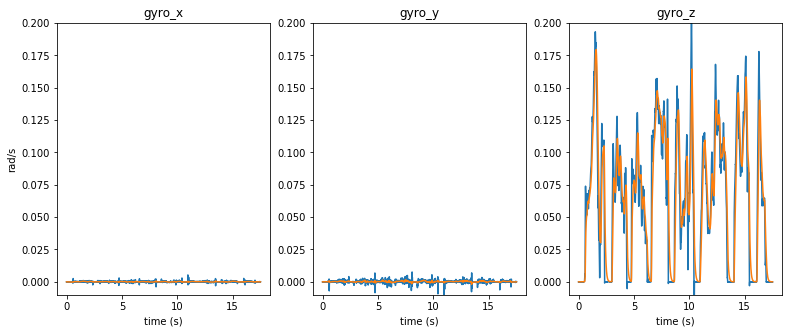

In [45]:
plt.rcParams['figure.figsize'] = (13, 5)
plt.subplot(131)
plt.plot(time, gyro1_total)
plt.plot(time, gyrohat1)
plt.title('gyro_x')
plt.xlabel('time (s)')
plt.ylabel('rad/s')
plt.ylim([-0.010, 0.20])

plt.subplot(132)
plt.plot(time, gyro2_total)
plt.plot(time, gyrohat2)
plt.title('gyro_y')
plt.xlabel('time (s)')
plt.ylim([-0.010, 0.20])

plt.subplot(133)
plt.plot(time, gyro3_total)
plt.plot(time, gyrohat3)
plt.title('gyro_z')
plt.xlabel('time (s)')
plt.ylim([-0.010, 0.20])

Text(0.5,0,u'time (s)')

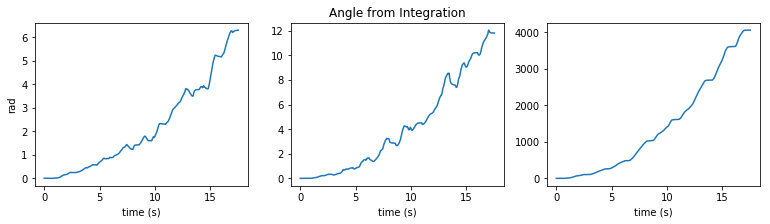

In [1139]:
plt.rcParams['figure.figsize'] = (13, 3)
pp1 = inTegrate(gyrohat1, time)
plt.subplot(131)
plt.ylabel('rad')
plt.plot(time, pp1)
plt.xlabel('time (s)')

pp2 = inTegrate(gyrohat2, time)
plt.subplot(132)
plt.plot(time, pp2)
plt.xlabel('time (s)')
plt.title('Angle from Integration')

pp3 = inTegrate(gyrohat3, time)
plt.subplot(133)
plt.plot(time, pp3)
plt.xlabel('time (s)')

# 3.3 Rotation Along x Axis

(-0.3, 0.2)

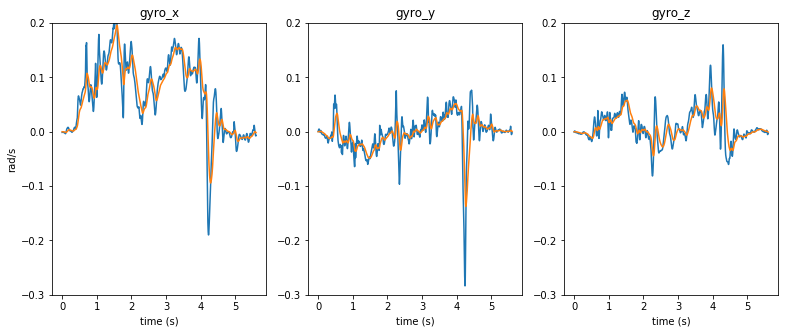

In [46]:
std = pd.read_csv('sensors/x3.csv', index_col = None, header = None)

time = std[std[1]==' GYRO_UN'][0].values
time = timeStamp(time)

gyro1 = std[std[1]==' GYRO_UN'][2].values
gyro2 = std[std[1]==' GYRO_UN'][3].values
gyro3 = std[std[1]==' GYRO_UN'][4].values

gyro1_bias = std[std[1]==' GYRO_UN'][5].values
gyro2_bias = std[std[1]==' GYRO_UN'][6].values
gyro3_bias = std[std[1]==' GYRO_UN'][7].values

gyro1_total = [mapGyro(x) for x in (gyro1 - gyro1_bias)]
gyro2_total = [mapGyro(x) for x in (gyro2 - gyro2_bias)]
gyro3_total = [mapGyro(x) for x in (gyro3 - gyro3_bias)]

gyrohat1 = defKF(gyro1_total, R, Q, x)
gyrohat2 = defKF(gyro2_total, R, Q, x)
gyrohat3 = defKF(gyro3_total, R, Q, x)

plt.subplot(131)
plt.plot(time, gyro1_total)
plt.plot(time, gyrohat1)
plt.ylabel('rad/s')
plt.title('gyro_x')
plt.xlabel('time (s)')
plt.ylim([-0.30, 0.20])

plt.subplot(132)
plt.plot(time, gyro2_total)
plt.plot(time, gyrohat2)
plt.title('gyro_y')
plt.xlabel('time (s)')
plt.ylim([-0.30, 0.20])

plt.subplot(133)
plt.plot(time, gyro3_total)
plt.plot(time, gyrohat3)
plt.title('gyro_z')
plt.xlabel('time (s)')
plt.ylim([-0.30, 0.20])

Text(0.5,0,u'time (s)')

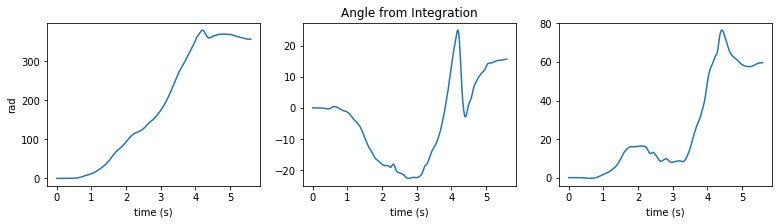

In [1141]:
pp1 = inTegrate(gyrohat1, time)
plt.subplot(131)
plt.ylabel('rad')
plt.plot(time, pp1)
plt.xlabel('time (s)')

pp2 = inTegrate(gyrohat2, time)
plt.subplot(132)
plt.plot(time, pp2)
plt.xlabel('time (s)')
plt.title('Angle from Integration')

pp3 = inTegrate(gyrohat3, time)
plt.subplot(133)
plt.plot(time, pp3)
plt.xlabel('time (s)')

# 3. Rotation Along y Axis

(-0.1, 0.38)

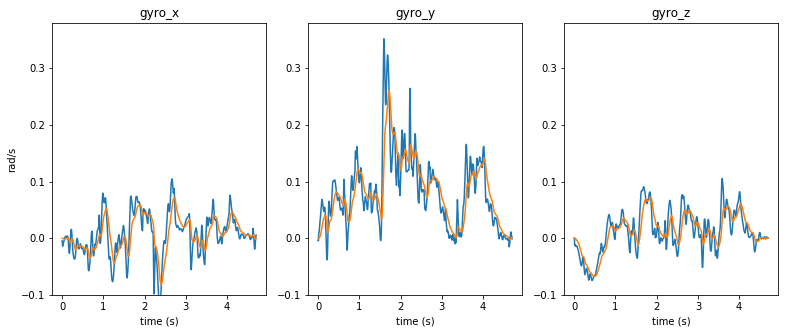

In [50]:
std = pd.read_csv('sensors/y3.csv', index_col = None, header = None)

time = std[std[1]==' GYRO_UN'][0].values
time = timeStamp(time)

gyro1 = std[std[1]==' GYRO_UN'][2].values
gyro2 = std[std[1]==' GYRO_UN'][3].values
gyro3 = std[std[1]==' GYRO_UN'][4].values

gyro1_bias = std[std[1]==' GYRO_UN'][5].values
gyro2_bias = std[std[1]==' GYRO_UN'][6].values
gyro3_bias = std[std[1]==' GYRO_UN'][7].values

gyro1_total = [mapGyro(x) for x in (gyro1 - gyro1_bias)]
gyro2_total = [mapGyro(x) for x in (gyro2 - gyro2_bias)]
gyro3_total = [mapGyro(x) for x in (gyro3 - gyro3_bias)]

gyrohat1 = defKF(gyro1_total, R, Q, x)
gyrohat2 = defKF(gyro2_total, R, Q, x)
gyrohat3 = defKF(gyro3_total, R, Q, x)

plt.subplot(131)
plt.plot(time, gyro1_total)
plt.plot(time, gyrohat1)
plt.ylabel('rad/s')
plt.title('gyro_x')
plt.xlabel('time (s)')
plt.ylim([-0.10, 0.38])

plt.subplot(132)
plt.plot(time, gyro2_total)
plt.plot(time, gyrohat2)
plt.title('gyro_y')
plt.xlabel('time (s)')
plt.ylim([-0.10, 0.38])

plt.subplot(133)
plt.plot(time, gyro3_total)
plt.plot(time, gyrohat3)
plt.title('gyro_z')
plt.xlabel('time (s)')
plt.ylim([-0.10, 0.38])

Text(0.5,0,u'time (s)')

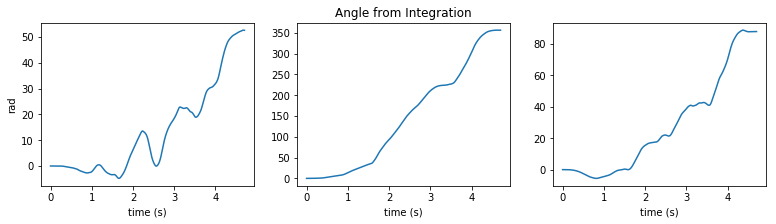

In [1148]:
pp1 = inTegrate(gyrohat1, time)
plt.subplot(131)
plt.ylabel('rad')
plt.plot(time, pp1)
plt.xlabel('time (s)')

pp2 = inTegrate(gyrohat2, time)
plt.subplot(132)
plt.plot(time, pp2)
plt.xlabel('time (s)')
plt.title('Angle from Integration')

pp3 = inTegrate(gyrohat3, time)
plt.subplot(133)
plt.plot(time, pp3)
plt.xlabel('time (s)')

# 4. Rotation Along z Axis

(-0.2, 0.05)

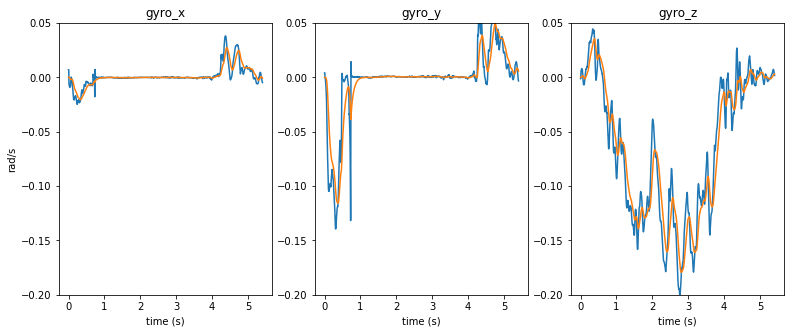

In [51]:
std = pd.read_csv('sensors/z.csv', index_col = None, header = None)

time = std[std[1]==' GYRO_UN'][0].values
time = timeStamp(time)

gyro1 = std[std[1]==' GYRO_UN'][2].values
gyro2 = std[std[1]==' GYRO_UN'][3].values
gyro3 = std[std[1]==' GYRO_UN'][4].values

gyro1_bias = std[std[1]==' GYRO_UN'][5].values
gyro2_bias = std[std[1]==' GYRO_UN'][6].values
gyro3_bias = std[std[1]==' GYRO_UN'][7].values

gyro1_total = [mapGyro(x) for x in (gyro1 - gyro1_bias)]
gyro2_total = [mapGyro(x) for x in (gyro2 - gyro2_bias)]
gyro3_total = [mapGyro(x) for x in (gyro3 - gyro3_bias)]

gyrohat1 = defKF(gyro1_total, R, Q, x)
gyrohat2 = defKF(gyro2_total, R, Q, x)
gyrohat3 = defKF(gyro3_total, R, Q, x)

plt.subplot(131)
plt.plot(time, gyro1_total)
plt.plot(time, gyrohat1)
plt.ylabel('rad/s')
plt.title('gyro_x')
plt.xlabel('time (s)')
plt.ylim([-0.20, 0.05])

plt.subplot(132)
plt.plot(time, gyro2_total)
plt.plot(time, gyrohat2)
plt.title('gyro_y')
plt.xlabel('time (s)')
plt.ylim([-0.20, 0.05])

plt.subplot(133)
plt.plot(time, gyro3_total)
plt.plot(time, gyrohat3)
plt.title('gyro_z')
plt.xlabel('time (s)')
plt.xlabel('time (s)')
plt.ylim([-0.20, 0.05])

Text(0.5,0,u'time (s)')

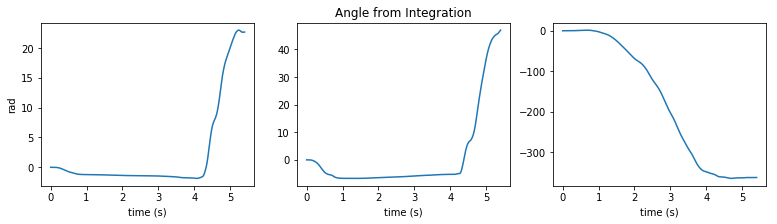

In [1150]:
pp1 = inTegrate(gyrohat1, time)
plt.subplot(131)
plt.ylabel('rad')
plt.plot(time, pp1)
plt.xlabel('time (s)')

pp2 = inTegrate(gyrohat2, time)
plt.subplot(132)
plt.plot(time, pp2)
plt.xlabel('time (s)')
plt.title('Angle from Integration')

pp3 = inTegrate(gyrohat3, time)
plt.subplot(133)
plt.plot(time, pp3)
plt.xlabel('time (s)')

# Walking

In [52]:
std = pd.read_csv('straightWalk/2.csv', index_col = None, header = None)

In [53]:
std[0]=timeStamp(std[0])

In [54]:
std.head()

,0,1,2,3,4,5,6,7
0,0.000977,MAG_UN,126.783752,-26.527405,-34.106445,87.498474,-20.954895,5.076599
1,0.000000,ACC_UN,-0.351746,1.677368,9.901505,0.000000,0.000000,0.000000
2,0.002411,ACC_UN,-0.351746,1.677368,9.901505,0.000000,0.000000,0.000000
3,0.000000,GYRO_UN,0.174088,0.070847,0.026871,0.008728,-0.009338,-0.018936
4,0.002411,GYRO_UN,0.174088,0.070847,0.026871,0.008728,-0.009338,-0.018936


## Accelerations 

In [55]:
acc = pd.DataFrame(std[std[1]==' ACC_UN'])
acc.reset_index(drop=True, inplace=True)

In [56]:
acc.head()

,0,1,2,3,4,5,6,7
0,0.000000,ACC_UN,-0.351746,1.677368,9.901505,0.0,0.0,0.0
1,0.002411,ACC_UN,-0.351746,1.677368,9.901505,0.0,0.0,0.0
2,0.004822,ACC_UN,-0.351746,1.677368,9.901505,0.0,0.0,0.0
3,0.007233,ACC_UN,-0.351746,1.677368,9.901505,0.0,0.0,0.0
4,0.009674,ACC_UN,-0.323029,1.694122,9.499512,0.0,0.0,0.0


### Time Stamp 

In [57]:
time_acc = acc[0].values

### Acc_x

In [58]:
accx = acc[2].values
accy = acc[3].values

In [61]:
acchatx = defKF(accx, R, Q, x)

Text(0,0.5,u'y acc [m/s^2]')

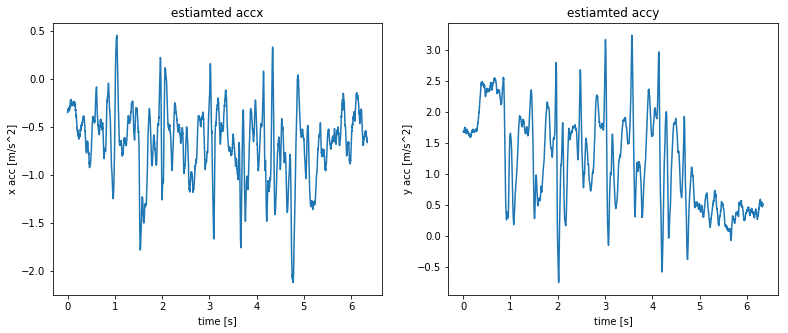

In [62]:
plt.subplot(121)
plt.plot(time_acc, accx)
plt.title('estiamted accx')
plt.xlabel('time [s]')
plt.ylabel('x acc [m/s^2]')

plt.subplot(122)
plt.plot(time_acc, accy)
plt.title('estiamted accy')
plt.xlabel('time [s]')
plt.ylabel('y acc [m/s^2]')

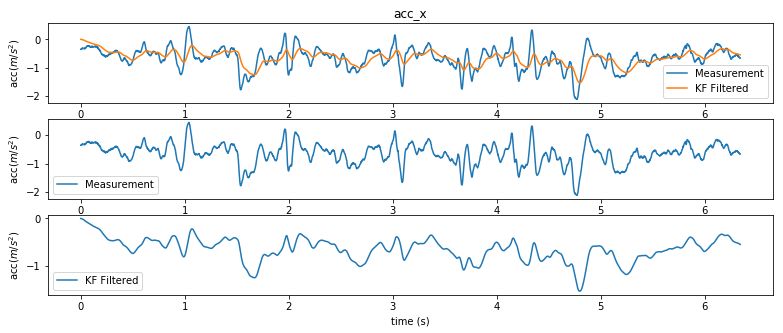

In [63]:
plt.subplot(311)
plt.plot(time_acc, accx)
plt.plot(time_acc, acchatx)
plt.title('acc_x')
plt.ylabel('acc($m/s^2$)')
plt.legend(['Measurement', 'KF Filtered'])

plt.subplot(312)
plt.plot(time_acc, accx)
plt.ylabel('acc($m/s^2$)')
plt.legend(['Measurement'])

plt.subplot(313)
plt.plot(time_acc, acchatx)
plt.xlabel('time (s)')
plt.ylabel('acc($m/s^2$)')
plt.legend(['KF Filtered'])

### Acc_y

In [64]:
acc_y = std[std[1]==' ACC_UN'][3].values

In [65]:
acchaty = defKF(acc_y, R, Q, x)

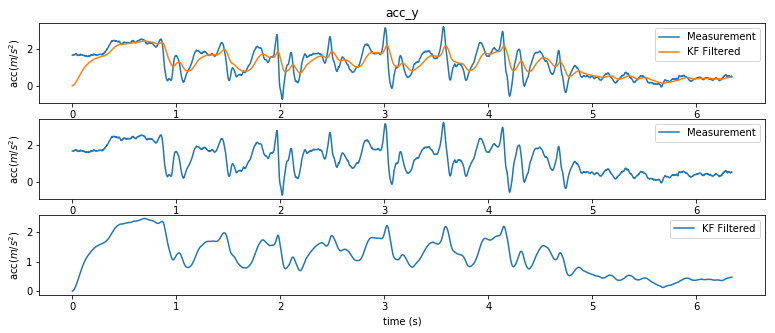

In [66]:
plt.subplot(311)
plt.plot(time_acc, acc_y)
plt.plot(time_acc, acchaty)
plt.title('acc_y')
plt.ylabel('acc($m/s^2$)')
plt.legend(['Measurement', 'KF Filtered'])

plt.subplot(312)
plt.plot(time_acc, acc_y)
plt.ylabel('acc($m/s^2$)')
plt.legend(['Measurement'])

plt.subplot(313)
plt.plot(time_acc, acchaty)
plt.xlabel('time (s)')
plt.ylabel('acc($m/s^2$)')
plt.legend(['KF Filtered'])

### Acc_z

In [67]:
acc_z = std[std[1]==' ACC_UN'][4].values

In [68]:
acchatz = defKF(acc_z, R, Q, x)

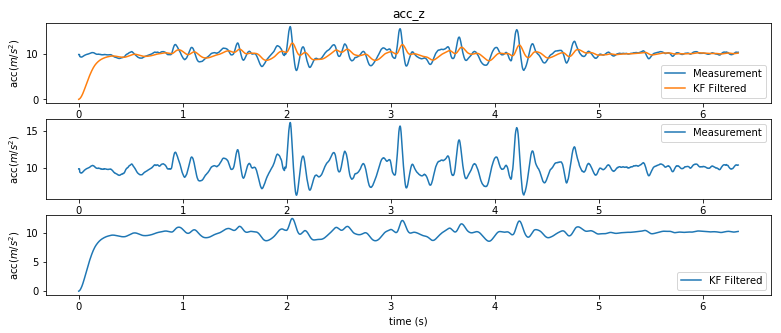

In [69]:
plt.subplot(311)
plt.plot(time_acc, acc_z)
plt.plot(time_acc, acchatz)
plt.title('acc_z')
plt.ylabel('acc($m/s^2$)')
plt.legend(['Measurement', 'KF Filtered'])

plt.subplot(312)
plt.plot(time_acc, acc_z)
plt.ylabel('acc($m/s^2$)')
plt.legend(['Measurement'])

plt.subplot(313)
plt.plot(time_acc, acchatz)
plt.xlabel('time (s)')
plt.ylabel('acc($m/s^2$)')
plt.legend(['KF Filtered'])

## Magnetometer 

In [71]:
mag = std[std[1]==' MAG_UN']

In [72]:
time_mag = mag[0]

In [73]:
len(time_mag)

318

### Mag_x 

In [70]:
magx  = std[std[1]==' MAG_UN'][2]
magxC = std[std[1]==' MAG_UN'][5]

In [75]:
mag1_total = mapMag(magx, magxC)

(-3.141592653589793, 3.141592653589793)

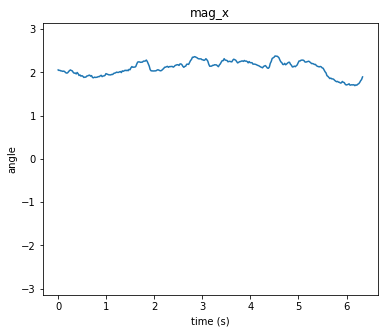

In [82]:
plt.rcParams['figure.figsize'] = (6, 5)
plt.plot(time_mag, mag1_total)
plt.xlabel('time (s)')
plt.ylabel('angle')
plt.title('mag_x')
plt.ylim([-math.pi, math.pi])

### Mag_y

In [77]:
magy  = std[std[1]==' MAG_UN'][3]
magyC = std[std[1]==' MAG_UN'][6]

In [78]:
mag2_total = mapMag(magy, magyC)

(-3.141592653589793, 3.141592653589793)

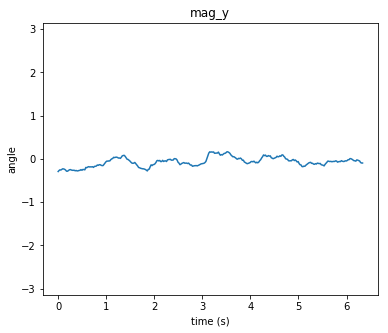

In [84]:
plt.rcParams['figure.figsize'] = (6, 5)
plt.plot(time_mag, mag2_total)
plt.xlabel('time (s)')
plt.ylabel('angle')
plt.title('mag_y')
plt.ylim([-math.pi, math.pi])

### Mag_z

In [86]:
magz  = std[std[1]==' MAG_UN'][4]
magzC = std[std[1]==' MAG_UN'][7]

In [87]:
mag3_total = mapMag(magz, magzC)

(-3.141592653589793, 3.141592653589793)

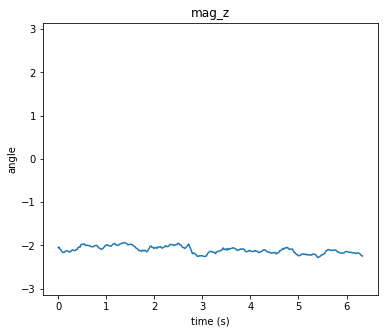

In [89]:
plt.rcParams['figure.figsize'] = (6, 5)
plt.plot(time_mag, mag3_total)
plt.xlabel('time (s)')
plt.ylabel('angle')
plt.title('mag_z')
plt.ylim([-math.pi, math.pi])

## Gyro 

In [94]:
gyro= std[std[1]==' GYRO_UN']

In [95]:
time_gyro = gyro[0]

In [96]:
gyrox = std[std[1]==' GYRO_UN'][2].values

In [97]:
gyrohatx = defKF(gyrox, R, Q, x)

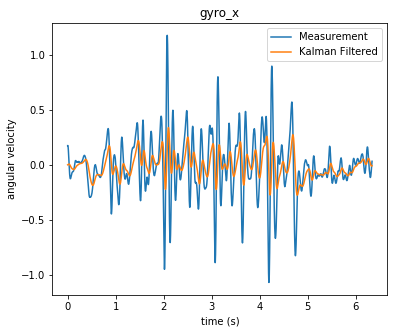

In [100]:
plt.plot(time_gyro, gyrox)
plt.plot(time_gyro, gyrohatx)
plt.xlabel('time (s)')
plt.ylabel('angular velocity')
plt.title('gyro_x')
plt.legend(['Measurement', 'Kalman Filtered'])

In [101]:
gyroy= std[std[1]==' GYRO_UN'][3].values
gyrohaty = defKF(gyroy, R, Q, x)

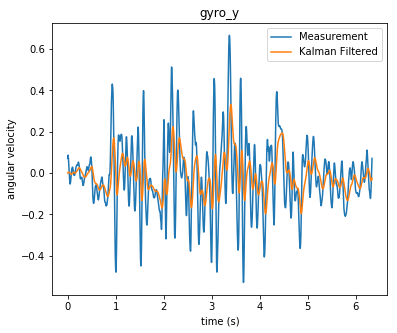

In [103]:
plt.plot(time_gyro, gyroy)
plt.plot(time_gyro, gyrohaty)
plt.xlabel('time (s)')
plt.ylabel('angular velocity')
plt.title('gyro_y')
plt.legend(['Measurement', 'Kalman Filtered'])

In [104]:
gyroz= std[std[1]==' GYRO_UN'][4].values
gyrohatz = defKF(gyroz, R, Q, x)

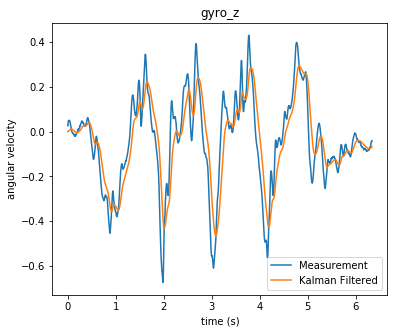

In [105]:
plt.plot(time_gyro, gyroz)
plt.plot(time_gyro, gyrohatz)
plt.xlabel('time (s)')
plt.ylabel('angular velocity')
plt.title('gyro_z')
plt.legend(['Measurement', 'Kalman Filtered'])

In [117]:
acc = pd.DataFrame(std[std[1]==' ACC_UN'])
acc.reset_index(drop=True, inplace=True)
acc = acc[0]
acc_part = acc[0:70]

In [118]:
mag = pd.DataFrame(std[std[1]==' MAG_UN'])
mag.reset_index(drop=True, inplace=True)
mag = mag[0]
mag_part = mag[0:70]

In [119]:
gyro = pd.DataFrame(std[std[1]==' GYRO_UN'])
gyro.reset_index(drop=True, inplace=True)
gyro = gyro[0]
gyro_part = gyro[0:70]

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


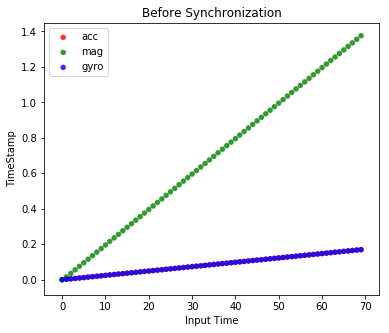

In [120]:
import numpy as np
import matplotlib.pyplot as plt

# Create data
g1 = (range(70), acc_part.values)
g2 = (range(70), mag_part.values)
g3 = (range(70), gyro_part.values)

data = (g1, g2, g3)
colors = ("red", "green", "blue")
groups = ("acc", "mag", "gyro")

# Create plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, axisbg="1.0")

for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
plt.rcParams['figure.figsize'] = (8, 7)
plt.title('Before Synchronization')
plt.legend(loc=2)
plt.xlabel('Input Time')
plt.ylabel('TimeStamp')
plt.show()

In [121]:
std_input_TS = std[0]
std_input_SE = std[1]

In [122]:
acc_stack  = []
mag_stack  = []
gyro_stack = []

acc_part_filter  = []
mag_part_filter  = []
gyro_part_filter = []

result = []
lagging_window = 8

Acc_missing = 5
Mag_missing = 11
Gyro_missing = 5

for i in range(5663):

    if(len(acc_stack)>0 and len(mag_stack)>0 and len(gyro_stack)>0):
        acc_time  = acc_stack[len(acc_stack)-1]
        mag_time  = mag_stack[len(mag_stack)-1]
        gyro_time = gyro_stack[len(gyro_stack)-1]
        
        if(abs(acc_time - mag_time)<lagging_window and abs(acc_time - gyro_time)<lagging_window and abs(mag_time - gyro_time)<lagging_window):
            result.append([acc_time, mag_time, gyro_time])
            acc_part_filter.append(acc_time)
            mag_part_filter.append(mag_time)
            gyro_part_filter.append(gyro_time)
            acc_stack = []
            mag_stack = []
            gyro_stack = []
        
    else:

        if std_input_SE[i] == ' ACC_UN':
            if len(acc_stack) > 0 and ((std_input_TS[i] - acc_stack[len(acc_stack)-1]) >= Acc_missing):
                    print('acc'+ str(std_input_TS[i]) + 'is missing')
                    acc_stack = []

            acc_stack.append(std_input_TS[i])
                
        elif std_input_SE[i] == ' MAG_UN':
            if len(mag_stack)>0 and ((std_input_TS[i] - mag_stack[len(mag_stack)-1]) >= Mag_missing):
                    print('mag'+ str(std_input_TS[i]) + 'is missing')
                    mag_stack = []
                   
            mag_stack.append(std_input_TS[i])
                
        elif std_input_SE[i] == ' GYRO_UN':
            if len(gyro_stack)>0 and ((std_input_TS[i] - gyro_stack[len(gyro_stack)-1]) >= Gyro_missing):
                    print('gyro'+ str(std_input_TS[i]) + 'is missing')
                    gyro_stack = []
                    
            gyro_stack.append(std_input_TS[i])
        
#         if(i<200):
#             print('acc_stack:', acc_stack, 'mag_stack:', mag_stack, 'gyro_stack:', gyro_stack)
 

In [123]:
result[0:10]

[[0.002410889, 0.000976563, 0.0],
 [0.017028809, 0.015655518, 0.017028809],
 [0.036743165, 0.035675049, 0.036743165],
 [0.058898926, 0.055969239, 0.058898926],
 [0.078582764, 0.075836182, 0.078582764],
 [0.098266602, 0.09564209, 0.098266602],
 [0.11795044, 0.115600586, 0.11795044],
 [0.137634278, 0.135620118, 0.137634278],
 [0.157348633, 0.155609131, 0.157348633],
 [0.177032471, 0.175567627, 0.177032471]]

# Length of Mag Dat == Length Synchronized Data

In [124]:
len(mag)

318

In [125]:
len(result)

318

# Save Mesuarement Data to .mat

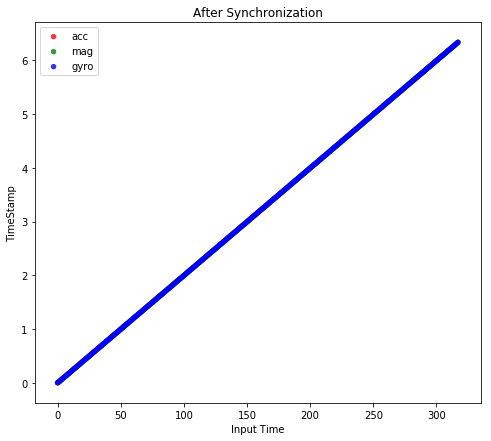

In [126]:
# Create data
g1 = (range(318), acc_part_filter)
g2 = (range(318), mag_part_filter)
g3 = (range(318), gyro_part_filter)

data = (g1, g2, g3)
colors = ("red", "green", "blue")
groups = ("acc", "mag", "gyro")

# Create plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, axisbg="1.0")

for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.rcParams['figure.figsize'] = (4, 4)
plt.title('After Synchronization')
plt.legend(loc=2)
plt.xlabel('Input Time')
plt.ylabel('TimeStamp')
plt.show()

In [127]:
acc = std[std[1]==' ACC_UN']
mag = std[std[1]==' MAG_UN']
gyro= std[std[1]==' GYRO_UN']

In [128]:
accx_syn = []
accy_syn = []
accz_syn = []
magx_syn = []
magy_syn = []
magz_syn = []
gyrox_syn = []
gyroy_syn = []
gyroz_syn = []

In [129]:
time = []

In [130]:
for i in range(len(result)):
    
    acc_time = result[i][0]
    time.append(acc_time)
    
    accx_syn.append(acc[acc[0] == acc_time][2].values[0])
    accy_syn.append(acc[acc[0] == acc_time][3].values[0])
    accz_syn.append(acc[acc[0] == acc_time][4].values[0])
        
    mag_time = result[i][1]
    magx_syn.append(mag[mag[0] == mag_time][2].values[0])
    magy_syn.append(mag[mag[0] == mag_time][3].values[0])
    magz_syn.append(mag[mag[0] == mag_time][4].values[0])
        
    gyro_time = result[i][2]
    gyrox_syn.append(gyro[gyro[0] == gyro_time][2].values[0])
    gyroy_syn.append(gyro[gyro[0] == gyro_time][3].values[0])
    gyroz_syn.append(gyro[gyro[0] == gyro_time][4].values[0])

In [572]:
import scipy.io
scipy.io.savemat('accx.mat', mdict={'accx': accx_syn})
scipy.io.savemat('accy.mat', mdict={'accy': accy_syn})
scipy.io.savemat('accz.mat', mdict={'accz': accy_syn})

In [597]:
scipy.io.savemat('time.mat', mdict={'time': time})
scipy.io.savemat('T.mat', mdict={'T': time_diff})

In [573]:
scipy.io.savemat('magx.mat', mdict={'magx': magx_syn})
scipy.io.savemat('magy.mat', mdict={'magy': magy_syn})
scipy.io.savemat('magz.mat', mdict={'magz': magy_syn})

In [574]:
scipy.io.savemat('gyrox.mat', mdict={'gyrox': gyrox_syn})
scipy.io.savemat('gyroy.mat', mdict={'gyroy': gyroy_syn})
scipy.io.savemat('gyroz.mat', mdict={'gyroz': gyroy_syn})

In [755]:
time_diff = np.zeros(len(time))

In [756]:
for i in range(len(time)-1):
    time_diff[i+1] =  1.0*(time[i+1] - time[i])

In [757]:
T = time_diff

# Estiamted Results from Matlab Code in GitLab

In [1260]:
est = pd.read_csv('straightWalk/x.csv', index_col = None, header = None)

In [1261]:
est.head()

,0,1,2,3,4,5,6,7,8,9,...,305,306,307,308,309,310,311,312,313,314
0,-1.628900e+00,-1.429900e+00,-1.192100e+00,-9.573600e-01,-7.346400e-01,-7.178200e-01,-9.871000e-01,-1.384200e+00,-1.650500e+00,-1.731800e+00,...,-1.670200e-01,-3.508700e-02,1.423500e-01,2.804500e-01,2.549900e-01,2.520700e-01,2.927100e-01,4.491900e-01,6.619600e-01,7.680500e-01
1,5.884600e-01,9.475600e-01,1.226500e+00,1.391700e+00,1.524300e+00,1.501100e+00,1.314600e+00,9.049100e-01,4.328700e-01,2.647900e-01,...,-4.304000e-01,-4.167000e-01,-4.216900e-01,-4.164200e-01,-4.564300e-01,-4.862800e-01,-5.535400e-01,-6.050800e-01,-4.849000e-01,-2.610200e-01
2,-8.877900e-14,-2.581300e-15,1.406700e-10,-4.966000e-11,2.148400e-18,3.233400e-26,-1.168800e-21,-1.740800e-15,6.087700e-11,-4.135900e-25,...,3.409400e-11,-1.718600e-23,-1.508400e-15,-4.013700e-11,7.270000e-12,1.045800e-10,-8.388500e-11,9.762500e-17,-7.607500e-10,1.341500e-10
3,1.174900e-22,-2.981100e-15,-1.107900e-10,3.568400e-11,4.951100e-23,-2.166000e-26,-2.670300e-23,-1.210400e-16,-1.406400e-10,2.197000e-26,...,-1.991700e-23,-3.590000e-25,-3.393900e-15,-1.317200e-10,1.346600e-10,1.416400e-10,-2.060100e-10,-3.602400e-17,-2.347500e-16,1.109600e-10
4,1.208500e-20,5.064300e-18,9.016300e-14,2.940300e-14,0.000000e+00,-1.026100e-40,1.266700e-37,1.231300e-21,-1.430600e-15,0.000000e+00,...,3.007600e-39,-4.524500e-39,2.796500e-18,-1.085400e-13,4.488600e-20,-1.440900e-15,-2.095700e-15,3.664500e-22,-2.311700e-21,5.256100e-25


# Double Integration

In [1262]:
accx = est.iloc[0].values

In [1263]:
accy = est.iloc[1].values

Text(0,0.5,u'y acc [m/s^2]')

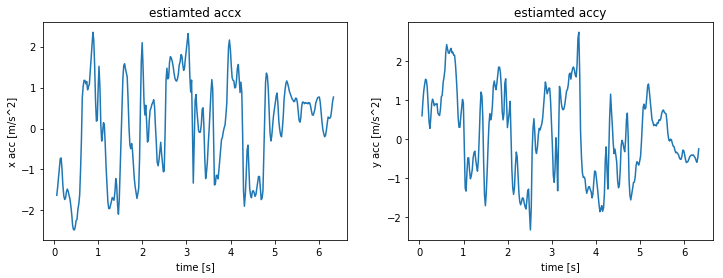

In [1264]:
plt.rcParams['figure.figsize'] = (12, 4)
plt.subplot(121)
plt.plot(time[3:len(time)], accx)
plt.title('estiamted accx')
plt.xlabel('time [s]')
plt.ylabel('x acc [m/s^2]')

plt.subplot(122)
plt.plot(time[3:len(time)], accy)
plt.title('estiamted accy')
plt.xlabel('time [s]')
plt.ylabel('y acc [m/s^2]')

In [1265]:
xx = np.zeros(315)
vx = np.zeros(315)
vx[0] = 0
vx[1] = accx[1]*T[1]
xx[1] = 0.5*accx[1]*T[1]**2

for i in range(2,315):
    vx[i] = accx[i-1]*T[i] + vx[i-1]
    xx[i] = vx[i]*T[i] + 0.5*accx[i]*T[i]**2 + xx[i-1]

Text(0,0.5,u'velocity (m/s)')

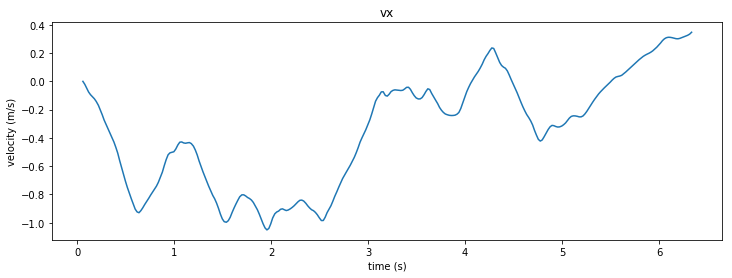

In [1266]:
plt.figure()
plt.plot(time[3:len(time)],vx)
plt.title('vx')
plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')

# Position X

Text(0,0.5,u'distance (m)')

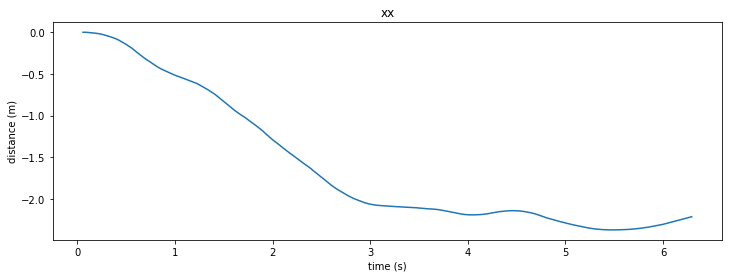

In [1269]:
plt.figure()
plt.plot(time[3:len(time)-2],pp[:-2])
plt.title('xx')
plt.xlabel('time (s)')
plt.ylabel('distance (m)')

In [1270]:
yy = np.zeros(315)
vy = np.zeros(315)
vy[0] = 0
vy[1] = accy[1]*T[1]
yy[1] = 0.5*accy[1]*T[1]**2

for i in range(2,315):
    vy[i] = accy[i-1]*T[i] + vy[i-1]
    yy[i] = vy[i]*T[i] + 0.5*accy[i]*T[i]**2 + yy[i-1]

Text(0,0.5,u'velocity (m/s)')

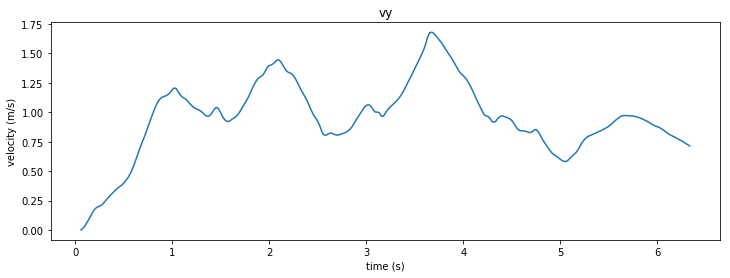

In [1271]:
plt.figure()
plt.plot(time[3:len(time)],vy)
plt.title('vy')
plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')

# Postion Y

Text(0,0.5,u'distance (m)')

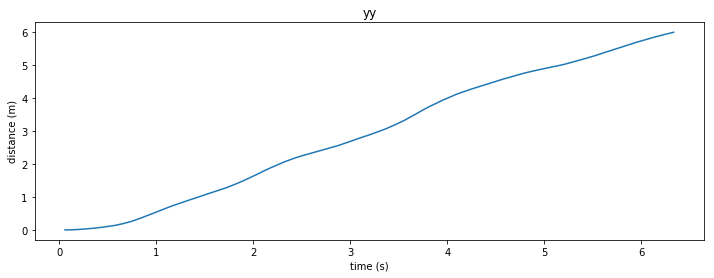

In [1272]:
plt.figure()
plt.plot(time[3:len(time)],yy)
plt.title('yy')
plt.xlabel('time (s)')
plt.ylabel('distance (m)')

In [153]:
std = pd.read_csv('straightWalk/2.csv', index_col = None, header = None)
std[0]=timeStamp(std[0])

In [154]:
acc_y = std[std[1]==' ACC_UN'][3].values
time =  std[std[1]==' ACC_UN'][0].values
acc_offset2 = 1.15
acc_y = accOff(acc_y, 2)
acchaty = defKF(acc_y, R, Q, x)

In [155]:
yy_ = doubleTegrate(acchaty, time)

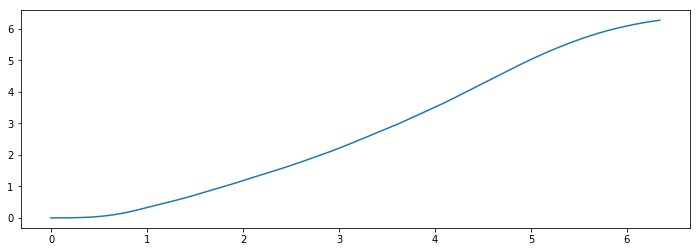

In [158]:
plt.rcParams['figure.figsize'] = (12, 4)
plt.plot(time, yy_)